# Exploratory analysis of timing and resource distributions
### by Jiachen Cong
## In this code, I have finished following analysis
### 1) Waiting time distribution (Start - Submit)
### 2) Submission patterns by weekday and hour of day
### 3) Runtime distribution (End - Start) for completed jobs
### 4) Resource request distributions: ReqCPUS, ReqMem, ReqNodes
### 5） Resource request distributions: Required GPUs
#### My main idea for this part is to extract as much information/patterns as possible from our data.
#### The data and code can be found at box. This code uses data set "master_2025_joblevel_submission.csv.gz" and "master_2025_joblevel_terminal.csv.gz". You just need to put this code with those data set in the same folder.
#### The data sets I used are based on Yanlin's "01_build_master_2025.ipynb". I made some minor modifications to Yanlin’s code (he set it up with a conda environment while I didn’t), but the data processing procedure and the output results remain the same.

In [16]:
# loading necessary packages
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# loading data
ROOT = Path.cwd()
SUB_PATH = ROOT / "master_2025_joblevel_submission.csv.gz"
TER_PATH = ROOT / "master_2025_joblevel_terminal.csv.gz"

assert SUB_PATH.exists(), f"Missing: {SUB_PATH}"
assert TER_PATH.exists(), f"Missing: {TER_PATH}"

# load the data
sub = pd.read_csv(SUB_PATH, compression="gzip")
ter = pd.read_csv(TER_PATH, compression="gzip")

# print the name of columns
print("Columns in sub:")
print(sub.columns.tolist())

print("\nColumns in ter:")
print(ter.columns.tolist())

# Count the number of tasks in different states
print(ter["State"].value_counts())

Columns in sub:
['JobIDRaw', 'User', 'Group', 'Account', 'Partition', 'QOS', 'Submit', 'State', 'Priority', 'ReqCPUS', 'ReqMem_MB', 'ReqNodes', 'ReqTRES', 'TimelimitRaw', 'AllocCPUS', 'AllocNodes']

Columns in ter:
['JobIDRaw', 'User', 'Group', 'Account', 'Partition', 'QOS', 'Submit', 'Eligible', 'State', 'Priority', 'ReqCPUS', 'ReqMem_MB', 'ReqNodes', 'ReqTRES', 'AllocCPUS', 'AllocNodes', 'Start', 'End', 'ElapsedRaw', 'TimelimitRaw', 'ExitCode', 'Reason', 'WaitTimeSec', 'RunTimeSec']
State
COMPLETED        4640994
CANCELLED         639013
FAILED            585112
TIMEOUT           116146
OUT_OF_MEMORY      43313
PENDING              515
NODE_FAIL            218
REQUEUED              13
RUNNING                2
Name: count, dtype: int64


### Convert timestamp columns to datetime format
### The raw CSV files store Submit, Start, and End as strings.
### I convert them to pandas datetime objects so that we can:
####   1) Compute time differences (e.g., Start - Submit)
####   2) Extract hour / weekday information
####  3) Perform proper time-based analysis
#### errors="coerce" ensures that invalid timestamps are safely converted to NaT instead of raising an exception.
#### I do this in both data sets mentioned above.

In [17]:
for df in (sub, ter):
    for c in ["Submit", "Start", "End"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

### Ensure numeric resource and duration columns are numeric
### Although these columns represent numbers (CPUs, memory, time), they may be loaded as strings from the CSV.
### We explicitly convert them to numeric types so that:
#### 1) Summary statistics (mean, percentiles) are correct
#### 2) Histograms and other plots work properly
#### 3) Arithmetic operations are valid
#### errors="coerce" converts invalid entries to NaN instead of failing.
#### I do this in both data sets mentioned above.

In [18]:
for df in (sub, ter):
    for c in ["ReqCPUS", "ReqNodes", "AllocCPUS", "AllocNodes", "ReqMem_MB", "WaitTimeSec", "RunTimeSec"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

print("submission shape:", sub.shape)
print("terminal shape:  ", ter.shape)

submission shape: (6025326, 16)
terminal shape:   (6025326, 24)


## Q1: Wait time distribution (Start - Submit)
### IMPORTANT: I use the terminal table ("master_2025_joblevel_terminal.csv.gz"), since it has Start/End and WaitTimeSec.
### Not include status: tasks in PENDING status; some tasks in CANCELLED status (tasks cancelled and not started)


=== Wait time (hours) summary ===
count    5.517282e+06
mean     6.953498e+00
std      3.126922e+01
min      0.000000e+00
50%      4.230556e-01
90%      1.300886e+01
95%      3.112944e+01
99%      1.160972e+02
max      6.865697e+03
Name: WaitTimeSec, dtype: float64


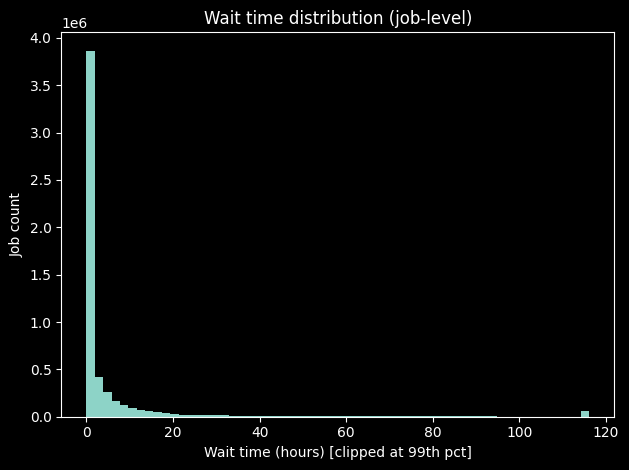

In [19]:
if "WaitTimeSec" in ter.columns:
    wait = ter["WaitTimeSec"]
else:
    # compute from timestamps if needed
    wait = (ter["Start"] - ter["Submit"]).dt.total_seconds()

wait = wait.replace([np.inf, -np.inf], np.nan).dropna()
wait_hr = wait / 3600.0

print("\n=== Wait time (hours) summary ===")
print(wait_hr.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(wait_hr.clip(upper=np.nanpercentile(wait_hr, 99)), bins=60)
plt.xlabel("Wait time (hours) [clipped at 99th pct]")
plt.ylabel("Job count")
plt.title("Wait time distribution (job-level)")
plt.tight_layout()
plt.show()

## Q2: Submission patterns by weekday and hour of day
#### In this section, I use the data set "master_2025_joblevel_submission.csv.gz".


=== Submissions by weekday ===
SubmitWeekday
Monday       864472
Tuesday      969666
Wednesday    837331
Thursday     814956
Friday       855459
Saturday     816110
Sunday       867332
Name: count, dtype: int64

=== Submissions by hour (0-23) ===
SubmitHour
0     271256
1     240464
2     220156
3     139365
4     123713
5     127304
6     137256
7     143170
8     179919
9     190417
10    276210
11    300606
12    295872
13    279835
14    304868
15    377099
16    359670
17    322188
18    294654
19    256135
20    244337
21    282626
22    350138
23    308068
Name: count, dtype: int64


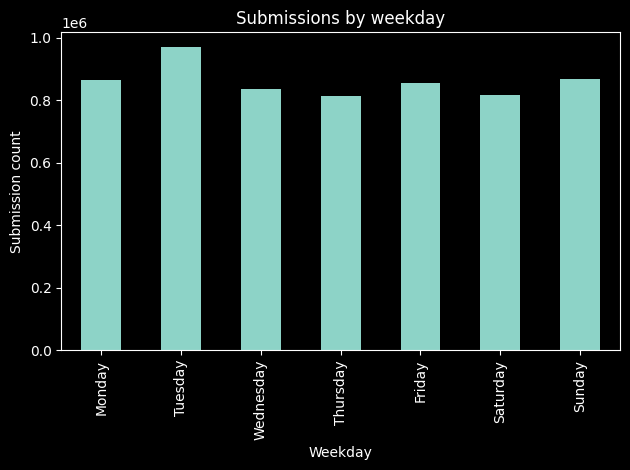

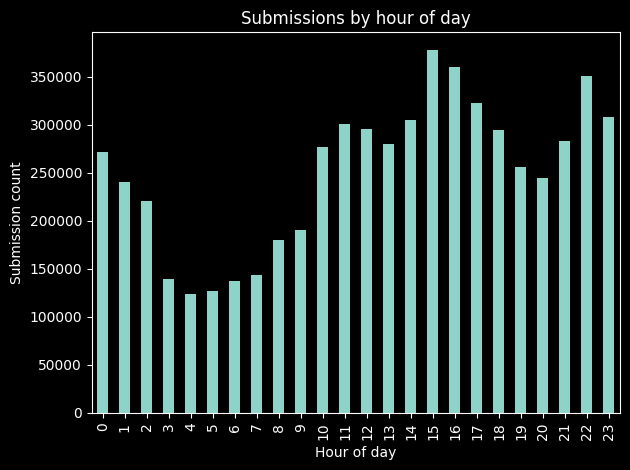

In [20]:
sub["SubmitHour"] = sub["Submit"].dt.hour
sub["SubmitWeekday"] = sub["Submit"].dt.day_name()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sub["SubmitWeekday"] = pd.Categorical(sub["SubmitWeekday"], categories=weekday_order, ordered=True)

weekday_counts = sub["SubmitWeekday"].value_counts().reindex(weekday_order)
hour_counts = sub["SubmitHour"].value_counts().sort_index()

print("\n=== Submissions by weekday ===")
print(weekday_counts)

print("\n=== Submissions by hour (0-23) ===")
print(hour_counts)

# Chart of Submissions by weekday (e.g., how many submission on monday, etc)
plt.figure()
weekday_counts.plot(kind="bar")
plt.xlabel("Weekday")
plt.ylabel("Submission count")
plt.title("Submissions by weekday")
plt.tight_layout()
plt.show()

# Chart of Submissions by hour of day (e.g., how many submission on 1 A.M., etc)
plt.figure()
hour_counts.plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Submission count")
plt.title("Submissions by hour of day")
plt.tight_layout()
plt.show()

## Q3: Runtime distribution (End - Start) for completed jobs
### IMPORTANT: In this section, I only summarize the running time for COMPLETED tasks. Since only these finished tasks have recorded start and end time.
#### The unit of runtime is hours.

Negative runtime count: 20 / 4,640,994 (0.000431%)

=== Runtime (COMPLETED only, hours) summary (after removing negative) ===
count    4.640974e+06
mean     5.589862e-01
std      3.363071e+00
min      0.000000e+00
50%      1.916667e-02
90%      1.058889e+00
95%      1.945653e+00
99%      1.039793e+01
max      6.271161e+02
Name: RunTimeSec, dtype: float64


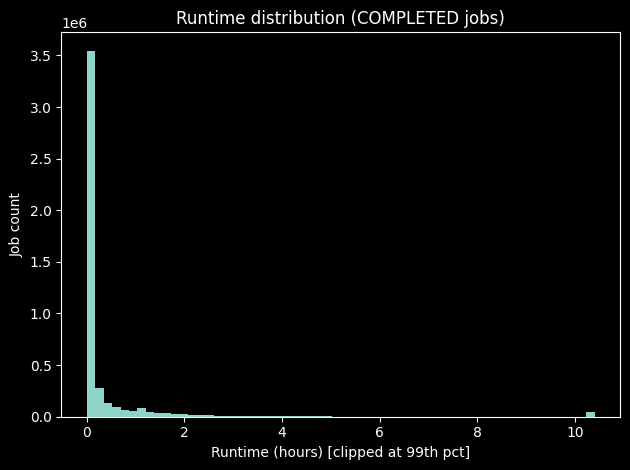

In [21]:
ter["State"] = ter["State"].astype(str).str.upper().str.strip()
completed = ter[ter["State"] == "COMPLETED"].copy()

# Compute runtime (prefer using the precomputed RunTimeSec from the data cleaning stage if available)
if "RunTimeSec" in completed.columns:
    runtime = completed["RunTimeSec"]
else:
    runtime = (completed["End"] - completed["Start"]).dt.total_seconds()

# # Clean the data: remove inf values and set impossible negative runtime values to missing
runtime = runtime.replace([np.inf, -np.inf], np.nan)

neg_cnt = (runtime < 0).sum()
valid_cnt = runtime.notna().sum()
print(f"Negative runtime count: {neg_cnt:,} / {valid_cnt:,} ({neg_cnt/valid_cnt:.6%})")

runtime = runtime.mask(runtime < 0, np.nan).dropna()
runtime_hr = runtime / 3600.0

print("\n=== Runtime (COMPLETED only, hours) summary (after removing negative) ===")
print(runtime_hr.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(runtime_hr.clip(upper=np.nanpercentile(runtime_hr, 99)), bins=60)
plt.xlabel("Runtime (hours) [clipped at 99th pct]")
plt.ylabel("Job count")
plt.title("Runtime distribution (COMPLETED jobs)")
plt.tight_layout()
plt.show()

## Q4: Resource request distributions: ReqCPUS, ReqMem, ReqNodes
####


=== ReqCPUS summary ===
count    6.025326e+06
mean     8.409819e+00
std      1.830992e+01
min      0.000000e+00
50%      4.000000e+00
90%      1.600000e+01
95%      2.800000e+01
99%      8.000000e+01
max      8.192000e+03
Name: ReqCPUS, dtype: float64

=== ReqNodes summary ===
count    6.025326e+06
mean     1.014275e+00
std      1.750785e-01
min      0.000000e+00
50%      1.000000e+00
90%      1.000000e+00
95%      1.000000e+00
99%      2.000000e+00
max      3.500000e+01
Name: ReqNodes, dtype: float64

=== ReqMem (GB) summary ===
count    6.025325e+06
mean     5.296862e+01
std      3.188396e+02
min      9.765625e-04
50%      1.600000e+01
90%      1.250000e+02
95%      1.804375e+02
99%      4.534180e+02
max      5.555500e+05
Name: ReqMem_MB, dtype: float64


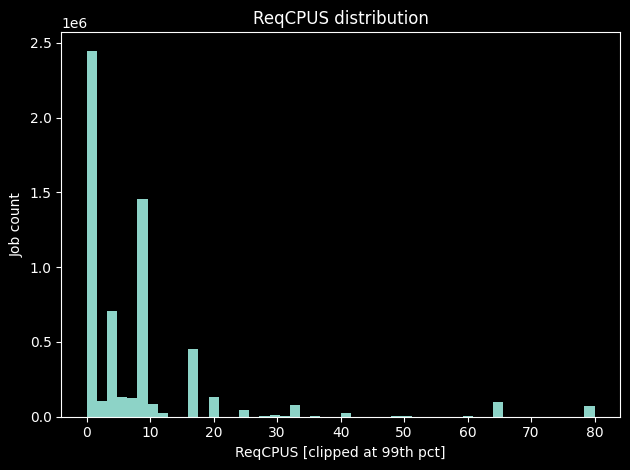

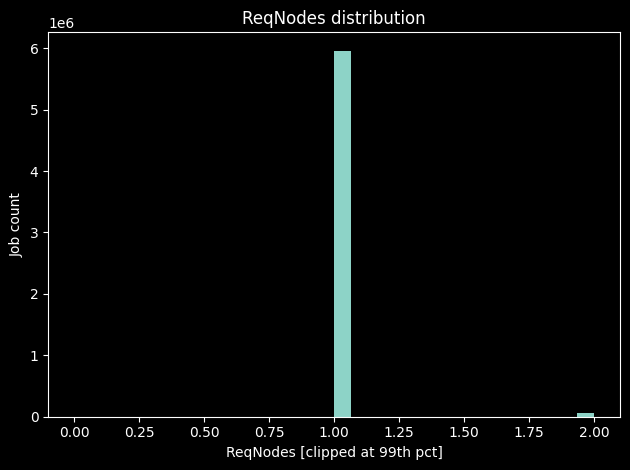

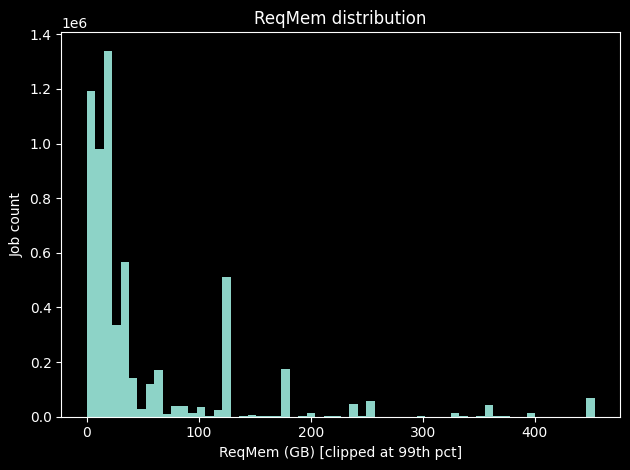

In [27]:
reqcpus = sub["ReqCPUS"].replace([np.inf, -np.inf], np.nan).dropna()
reqnodes = sub["ReqNodes"].replace([np.inf, -np.inf], np.nan).dropna()
reqmem_gb = (sub["ReqMem_MB"].replace([np.inf, -np.inf], np.nan).dropna()) / 1024.0

print("\n=== ReqCPUS summary ===")
print(reqcpus.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

print("\n=== ReqNodes summary ===")
print(reqnodes.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

print("\n=== ReqMem (GB) summary ===")
print(reqmem_gb.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(reqcpus.clip(upper=np.nanpercentile(reqcpus, 99)), bins=50)
plt.xlabel("ReqCPUS [clipped at 99th pct]")
plt.ylabel("Job count")
plt.title("ReqCPUS distribution")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(reqnodes.clip(upper=np.nanpercentile(reqnodes, 99)), bins=30)
plt.xlabel("ReqNodes [clipped at 99th pct]")
plt.ylabel("Job count")
plt.title("ReqNodes distribution")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(reqmem_gb.clip(upper=np.nanpercentile(reqmem_gb, 99)), bins=60)
plt.xlabel("ReqMem (GB) [clipped at 99th pct]")
plt.ylabel("Job count")
plt.title("ReqMem distribution")
plt.tight_layout()
plt.show()

## Q5: Resource request distributions: Required GPUs
#### This data is extracted from the column 'ReqTRES'.
#### I have done following jobs:
#### 1). Summarizing and visualizing the distribution of GPUs required (for jobs need GPUs)
#### 2). Wait time distribution for jobs need GPU (in hours)


=== GPU_Count frequency table (GPU jobs only) ===
GPU_Count
1     342443
2       6569
3        382
4       9999
5         39
6        913
7         25
8      21160
10        31
16       352
24      1231
28        12
30         5
32         1
40         2
64         1
Name: count, dtype: int64


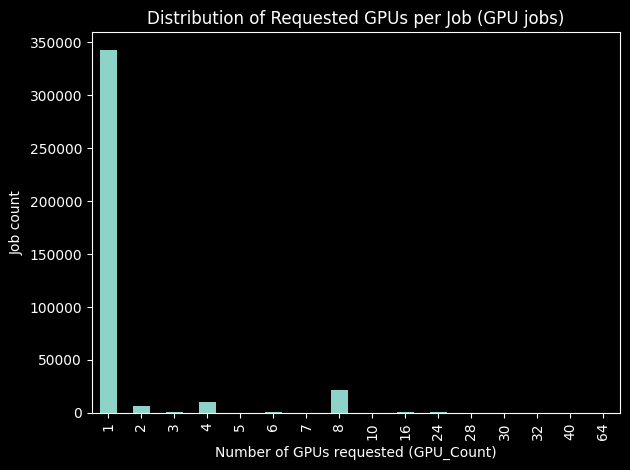


=== GPU jobs: Wait time (hours) summary ===
count    351136.000000
mean          8.811131
std          42.803429
min           0.000000
50%           0.086944
90%          24.132778
95%          48.572083
99%         112.733694
max        6865.696667
Name: WaitTimeSec, dtype: float64


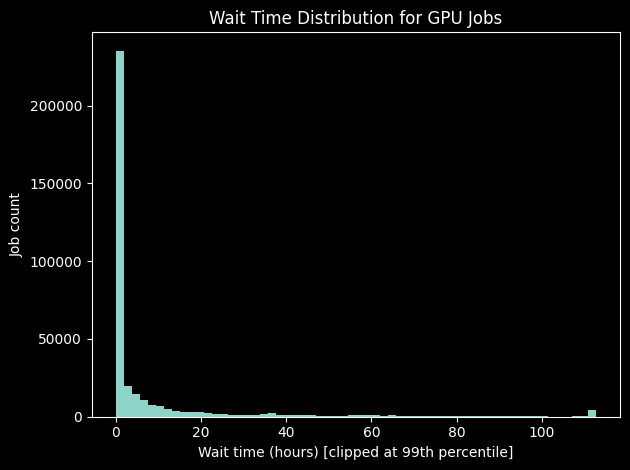

In [28]:
# Regular expression to match patterns like "gres/gpu=1"
gpu_pattern = re.compile(r"gres/gpu=([0-9]+)", re.IGNORECASE)
def extract_gpu_count(tres):
    if pd.isna(tres):
        return 0
    match = gpu_pattern.search(str(tres))
    if match:
        return int(match.group(1))
    return 0
# Create a new column indicating the number of GPUs requested
ter["GPU_Count"] = ter["ReqTRES"].apply(extract_gpu_count)

# Filter GPU jobs from the submission dataset
# A job is considered a GPU job if GPU_Count > 0.
# We create a new DataFrame sub_gpu containing only GPU jobs.
ter_gpu = ter[(ter["GPU_Count"] > 0) & (ter["GPU_Count"] <= 64)].copy()

# GPU request distribution (how many GPUs per job)
gpu_freq = ter_gpu["GPU_Count"].value_counts().sort_index()
print("\n=== GPU_Count frequency table (GPU jobs only) ===")
print(gpu_freq)
plt.figure()
gpu_freq.plot(kind="bar")
plt.xlabel("Number of GPUs requested (GPU_Count)")
plt.ylabel("Job count")
plt.title("Distribution of Requested GPUs per Job (GPU jobs)")
plt.tight_layout()
plt.show()

# Wait time distribution for GPU jobs (in hours)
# Note: WaitTimeSec is computed in your cleaning pipeline.
# We clean invalid values (inf / negative) and drop missing.
wait_gpu = ter_gpu["WaitTimeSec"].replace([np.inf, -np.inf], np.nan)
wait_gpu = wait_gpu.mask(wait_gpu < 0, np.nan).dropna()
wait_gpu_hr = wait_gpu / 3600.0
print("\n=== GPU jobs: Wait time (hours) summary ===")
print(wait_gpu_hr.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))
plt.figure()
plt.hist(
    wait_gpu_hr.clip(upper=np.nanpercentile(wait_gpu_hr, 99)),
    bins=60
)
plt.xlabel("Wait time (hours) [clipped at 99th percentile]")
plt.ylabel("Job count")
plt.title("Wait Time Distribution for GPU Jobs")
plt.tight_layout()
plt.show()


#### These questions provide an overview of behavioral patterns and workload structure.
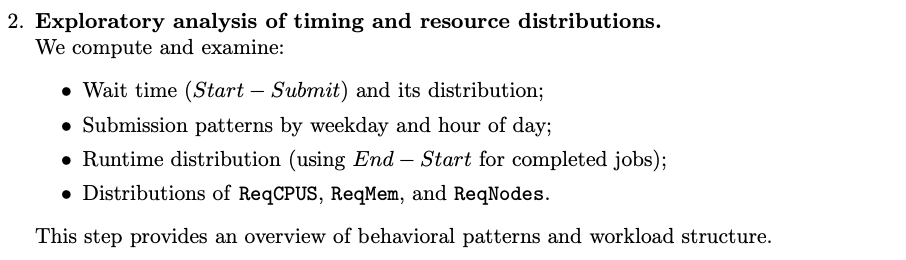